In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S,ST
from holotomocupy.tomo import R, RT
from holotomocupy.chunking import gpu_batch
import holotomocupy.chunking as chunking
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *
from holotomocupy.proc import linear, dai_yuan
import sys

chunking.global_chunk = 64
%matplotlib inline
# !jupyter nbconvert --to script rec_reprojection_codes.ipynb

astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension

ntheta = 360  # number of angles (rotations)
noise = 0
z1c = -19.5e-3

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True



flg = f'{n}_{z1c}'
flg0 = f'{2048}_{z1c}'
path = f'/data2/vnikitin/nfp_codes'



## Read data

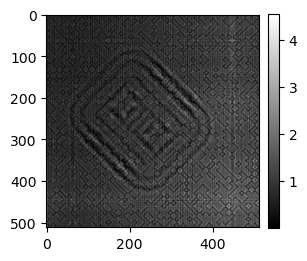

In [3]:
data = np.zeros([ntheta, npos, n, n], dtype='float32')
ref = np.zeros([1, npos, n, n], dtype='float32')
for k in range(npos):
    data[:, k] = read_tiff(f'{path}/data_3d_{k}_{flg}.tiff')[:ntheta]
for k in range(npos):
    ref[:, k] = read_tiff(f'{path}/ref_3d_{k}_{flg}.tiff')[:]

# data = cp.array(data)
# ref = cp.array(ref)
shifts_code = np.load(f'{path}/shifts_code_3d_{flg}.npy')
mshow(data[0,0],show)


(1, 2560, 2560)


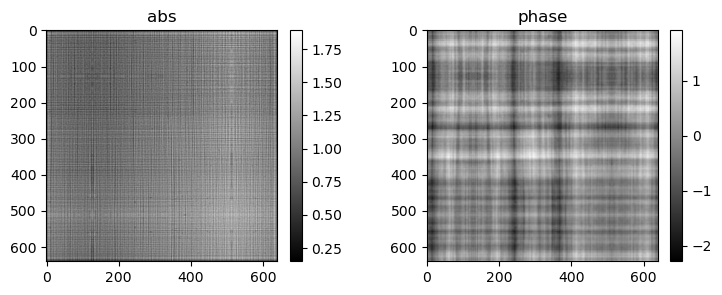

In [4]:
prb = np.load(f'{path}/prb_{flg0}.npy')
print(prb.shape)
for k in range(np.int32(np.log2(2048//n))):
    prb = 0.5*(prb[:,::2]+prb[:,1::2])
    prb = 0.5*(prb[:,:,::2]+prb[:,:,1::2])
mshow_polar(prb[0],show)

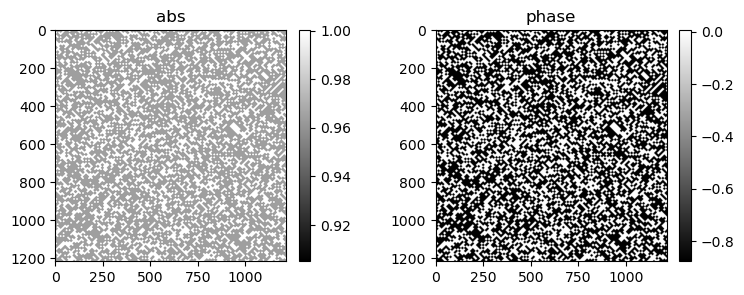

In [5]:
code = np.load(f'{path}/code_{flg0}.npy')
for k in range(np.int32(np.log2(2048//n))):
    code = 0.5*(code[:,::2]+code[:,1::2])
    code = 0.5*(code[:,:,::2]+code[:,:,1::2])
mshow_polar(code[0],show)

# Construct operators


In [6]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    #print(psi.shape)
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for j in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        coder = S(coder, shifts_code[:, j])
        coder = coder[:, coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2, 
                      coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2]
        # multiply by the probe
        coder *= prbr

        # propagate both to the sample plane
        coder = G(coder, wavelength, voxelsize, distances2[j])
        
        # multiply by the sample
        psir *= coder           

        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[j])

        # unpad
        data[:, j] = psir[:, pad:-pad,pad:-pad]
        
    return data

@gpu_batch
def _adj_holo(data, shifts_code, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        prbr = cp.tile(prb,[psi.shape[0],1,1])        
        coder = cp.tile(code,[psi.shape[0],1,1])
        
        coder = S(coder, shifts_code[:, j])
        coder = coder[:, coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2, 
                      coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2]
        coder *= prbr
        coder = G(coder, wavelength, voxelsize, distances2[j])

        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = GT(psir, wavelength, voxelsize, distances[j])
        psir *= cp.conj(coder)
        psi += psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi, code):
    psi = cp.array(psi)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = psi.copy()
        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        prbr*=cp.conj(psir)
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:, coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2, 
                      coder.shape[1]//2-ne//2:coder.shape[1]//2+ne//2]
        prbr *= cp.conj(coder)
        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb, code)
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_code, psi, code), axis=0)[np.newaxis]

# adjoint tests
tmp = data.copy()
arr1 = np.pad(np.array(tmp[:, 0]+1j*tmp[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')

prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')
print(f'{np.sum(prb1*np.conj(arr4))}==\n{np.sum(arr2*np.conj(arr2))}')

arr1 = arr1.swapaxes(0,1)
a = RT(arr1,theta,ne//2)
b = R(a,theta,ne//2)
c = RT(b,theta,ne//2)
print(f'{np.sum(arr1*np.conj(b))}==\n{np.sum(a*np.conj(a))}')
print(f'{np.sum(a*np.conj(a))}==\n{np.sum(a*np.conj(c))}')

(231150240-0.9865818023681641j)==
(231149440-0.00013602623948827386j)
(231149424-3.181396484375j)==
(231149440-0.00013602623948827386j)
(307382784+32.46376419067383j)==
(307382624-0.000773459323681891j)
(307382624-0.000773459323681891j)==
(308190208+17.6740665435791j)


### Propagate the code to the detector and divide all data by it

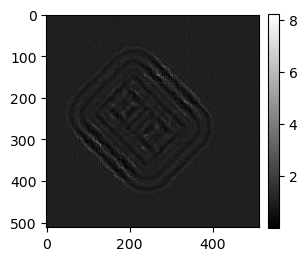

In [7]:
psi1 = np.ones([ntheta,ne,ne],dtype='complex64')
prb1 = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi1,prb1))**2

rdata = data/d/ref
mshow((rdata)[0,0],show)

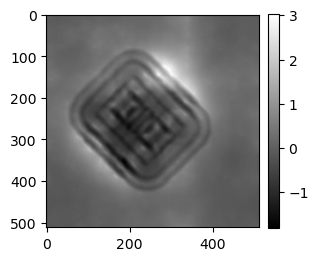

In [8]:
# distances should not be normalized
distances_pag = (distances)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  100, 1e-2))
mshow(np.angle(recMultiPaganin[0]),show)

#### Exponential and logarithm functions for the Transmittance function

In [9]:
def exptomo(psi):
    """Exp representation of projections"""
    return np.exp(1j*psi * voxelsize * 2*cp.pi / wavelength*np.sqrt(ne*ntheta))
    
def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    res = -1j * wavelength / (2*cp.pi) * res / voxelsize/np.sqrt(ne*ntheta)
    return res

# Operators for the flat field

In [10]:
def _fwd_holo0(prb):
    data = cp.zeros([1, npos, n, n], dtype='complex64')
    prb = cp.array(prb)
    for j in range(npos):
        # propagate illumination
        data[:, j] = G(prb, wavelength, voxelsize, distances[0])[:, pad:n+pad, pad:n+pad]
    return data.get()

def fwd_holo0(prb):
    return _fwd_holo0(prb)

def _adj_holo0(data):
    prb = cp.zeros([1, n+2*pad, n+2*pad], dtype='complex64')
    data =cp.array(data)
    for j in range(npos):
        # ill shift for each acquisition
        prbr = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        # propagate illumination
        prbr = GT(prbr, wavelength, voxelsize, distances[0])
        # ill shift for each acquisition
        prb += prbr
    return prb.get()

def adj_holo0(data):
    return _adj_holo0(data)


# adjoint test
tmp = data[0, :].copy()
prb1 = np.array(ref[0, :1]+1j*ref[0, :1]).astype('complex64')
prb1 = np.pad(prb1, ((0, 0), (pad, pad), (pad, pad)))
arr2 = fwd_holo0(prb1)
arr3 = adj_holo0(arr2)


print(f'{np.sum(prb1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(645336.1875+0.00472259521484375j)==
(645336.25+8.965766028268263e-06j)


In [11]:
def redot(a,b):
    return np.sum(a.real*b.real+a.imag*b.imag)

In [12]:
def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional    
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = cp.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    center_pad = u.shape[-1]//2
    for i in range(pars['titer']):
        fu = R(u,theta,center_pad)
        grad = 2*RT(fu-data,theta,center_pad)
        if i == 0:
            eta = -grad
        else:
            top = 2*redot(RT(R(grad,theta,center_pad),theta,center_pad),eta)
            bottom = 2*redot(RT(R(eta,theta,center_pad),theta,center_pad),eta)
            beta = top/bottom
            eta = -grad+beta*eta
        top = -redot(grad,eta)
        bottom = 2*redot(RT(R(eta,theta,center_pad),theta,center_pad),eta)
        alpha = top/bottom
        u +=alpha*eta
        print(i,alpha,minf(R(u,theta,center_pad)))
    return u


0 0.624153315146366 8984030.0
1 1.6805662090027267 4074714.0
2 2.9663617885881526 2664959.0
3 4.810363600885579 2118811.0
4 2.843538916923554 1898366.5
5 5.43568390112577 1678859.0
6 4.4541062633370325 1603899.9
7 0.7953352700533531 1579416.8


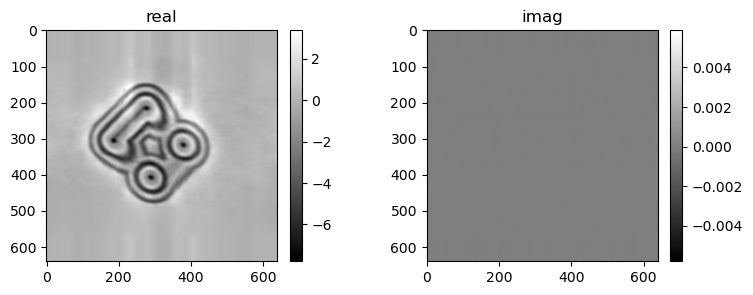

In [13]:
psirec = np.pad(np.array(recMultiPaganin),((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge')

#tomo initial guess
xi = 1/1j*np.log(psirec).swapaxes(0,1)

urec0 = np.zeros([ne,ne,ne],dtype='complex64')
pars = {'titer':8}
urec0 = cg_tomo(xi,urec0,pars)
mshow_complex(urec0[:,ne//2,:],show)

0), float(alpha)=0.8267236558311847 err=1.38533e+05


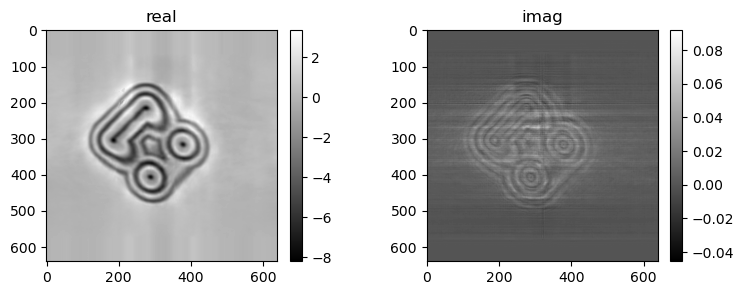

1), float(alpha)=2.117407648366158 err=1.25047e+05
2), float(alpha)=1.5184800443584323 err=1.10610e+05
3), float(alpha)=1.7736322296052247 err=9.61967e+04
4), float(alpha)=1.7191422915953143 err=7.76716e+04
5), float(alpha)=1.216382336918147 err=6.52215e+04
6), float(alpha)=1.5529858081180394 err=5.35724e+04
7), float(alpha)=1.3778007255825855 err=4.39264e+04
8), float(alpha)=1.4133038644750167 err=3.82350e+04
9), float(alpha)=1.6582666788672482 err=3.29513e+04
10), float(alpha)=1.346463747464002 err=2.92806e+04
11), float(alpha)=1.68259304717145 err=2.58133e+04
12), float(alpha)=1.454420596055408 err=2.29618e+04
13), float(alpha)=1.4755921202132982 err=2.05983e+04
14), float(alpha)=1.5097131868517806 err=1.81168e+04
15), float(alpha)=1.6560490615694883 err=1.60543e+04
16), float(alpha)=1.807052514133377 err=1.41253e+04


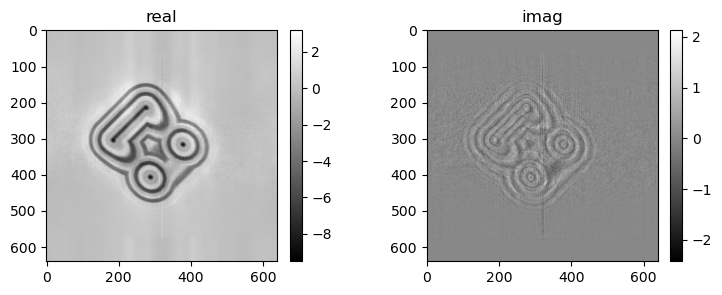

17), float(alpha)=1.3934064218146103 err=1.27434e+04
18), float(alpha)=1.4468376916111765 err=1.15023e+04
19), float(alpha)=1.357324835036427 err=1.03431e+04
20), float(alpha)=1.5941235367141307 err=9.37212e+03
21), float(alpha)=1.6165683820453687 err=8.47899e+03
22), float(alpha)=1.519812815089432 err=7.79007e+03
23), float(alpha)=1.5628110335550445 err=7.12155e+03
24), float(alpha)=1.5038313971737136 err=6.57554e+03
25), float(alpha)=1.6587756929282118 err=6.06629e+03
26), float(alpha)=1.5692683574821937 err=5.62129e+03
27), float(alpha)=1.6027506985524738 err=5.22805e+03
28), float(alpha)=1.5744331386293262 err=4.88162e+03
29), float(alpha)=1.4325765986517838 err=4.57974e+03
30), float(alpha)=1.4736053976379417 err=4.28035e+03
31), float(alpha)=1.476025205502666 err=4.03363e+03
32), float(alpha)=1.567375364954708 err=3.79721e+03


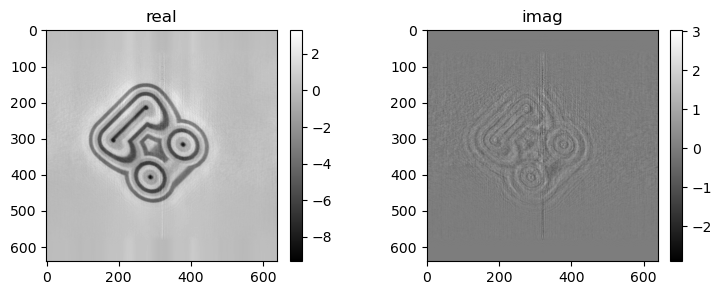

33), float(alpha)=1.5519758562132333 err=3.57447e+03
34), float(alpha)=1.5687536949652885 err=3.38048e+03
35), float(alpha)=1.5986920903873671 err=3.19464e+03
36), float(alpha)=1.5273969582246256 err=3.03445e+03
37), float(alpha)=1.6633221700174539 err=2.87127e+03
38), float(alpha)=1.5101247554216488 err=2.73640e+03
39), float(alpha)=1.4881517494579013 err=2.60893e+03
40), float(alpha)=1.609823994956759 err=2.47916e+03
41), float(alpha)=1.6537320983101698 err=2.36945e+03
42), float(alpha)=1.6657565153923377 err=2.25766e+03
43), float(alpha)=1.391010281000006 err=2.17000e+03
44), float(alpha)=1.4877122196566024 err=2.08087e+03
45), float(alpha)=1.5856517704188806 err=1.98843e+03
46), float(alpha)=1.614456898295252 err=1.91333e+03
47), float(alpha)=1.5561894581482598 err=1.83654e+03
48), float(alpha)=1.5427981433433497 err=1.76714e+03


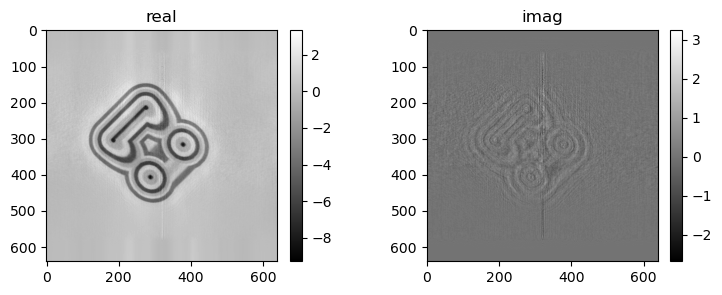

49), float(alpha)=1.599068837612974 err=1.70025e+03
50), float(alpha)=1.6654059139193773 err=1.63276e+03
51), float(alpha)=1.812456855916758 err=1.57124e+03
52), float(alpha)=1.7572281310835816 err=1.51183e+03
53), float(alpha)=1.4469548516346462 err=1.46118e+03
54), float(alpha)=1.549134470405542 err=1.41057e+03
55), float(alpha)=1.4987818249809444 err=1.36161e+03
56), float(alpha)=1.5760055916937803 err=1.31491e+03
57), float(alpha)=1.662715517013485 err=1.26873e+03
58), float(alpha)=1.4468739219113689 err=1.22762e+03
59), float(alpha)=1.5869067579348985 err=1.18581e+03
60), float(alpha)=1.5639251465914028 err=1.14517e+03
61), float(alpha)=1.6305049611044773 err=1.10660e+03
62), float(alpha)=1.5894655776218747 err=1.07067e+03
63), float(alpha)=1.6349859351542617 err=1.03408e+03
64), float(alpha)=1.6083001540116195 err=9.98852e+02


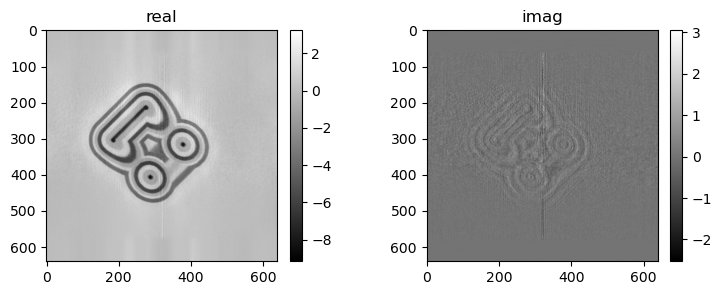

65), float(alpha)=1.780789861203389 err=9.64789e+02
66), float(alpha)=1.7232855676396228 err=9.31081e+02
67), float(alpha)=1.603738243215411 err=9.01899e+02
68), float(alpha)=1.4457514563013316 err=8.72993e+02
69), float(alpha)=1.4802265893147037 err=8.44965e+02
70), float(alpha)=1.6074605439554575 err=8.18043e+02
71), float(alpha)=1.5813918215443639 err=7.90995e+02
72), float(alpha)=1.7521168055939103 err=7.64148e+02
73), float(alpha)=1.6102686920230769 err=7.39411e+02
74), float(alpha)=1.447054381175006 err=7.17157e+02
75), float(alpha)=1.6239034141396382 err=6.93469e+02
76), float(alpha)=1.593618116142723 err=6.71018e+02
77), float(alpha)=1.7500414081418114 err=6.48713e+02
78), float(alpha)=1.6641822809760183 err=6.27348e+02
79), float(alpha)=1.5813517570884412 err=6.07355e+02
80), float(alpha)=1.5519379445819983 err=5.88303e+02


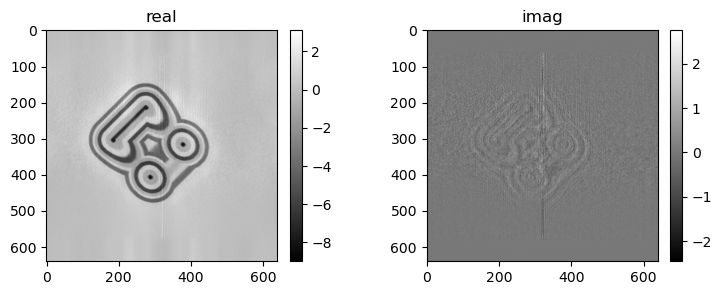

81), float(alpha)=1.500917212061591 err=5.69941e+02
82), float(alpha)=1.6943026271160324 err=5.51540e+02
83), float(alpha)=1.4518957974532067 err=5.34985e+02
84), float(alpha)=1.447949820625543 err=5.18596e+02
85), float(alpha)=1.7434663799813912 err=5.01318e+02
86), float(alpha)=1.6850189201792747 err=4.85454e+02
87), float(alpha)=1.65587988812389 err=4.70149e+02
88), float(alpha)=1.6289137746149231 err=4.55441e+02
89), float(alpha)=1.6505058573460953 err=4.41229e+02
90), float(alpha)=1.5713689240053714 err=4.27892e+02
91), float(alpha)=1.6527800177458494 err=4.14773e+02
92), float(alpha)=1.67902474929894 err=4.01779e+02
93), float(alpha)=1.4283918762040608 err=3.90694e+02
94), float(alpha)=1.4749376246838504 err=3.79217e+02
95), float(alpha)=1.5910067849328862 err=3.68066e+02
96), float(alpha)=1.761774399937863 err=3.56599e+02


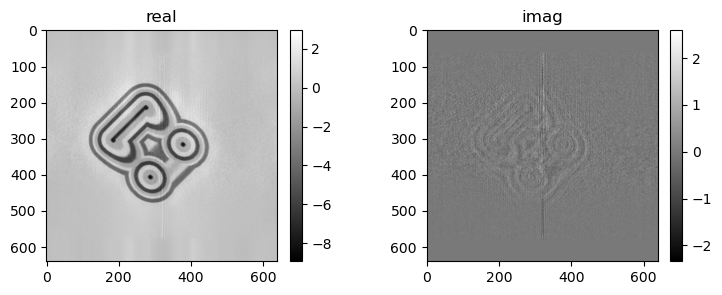

97), float(alpha)=1.5387490694929544 err=3.46319e+02
98), float(alpha)=1.5731759880881677 err=3.36615e+02
99), float(alpha)=1.5612746486358058 err=3.26909e+02
100), float(alpha)=1.551286662880816 err=3.17615e+02
101), float(alpha)=1.761894326403122 err=3.08043e+02
102), float(alpha)=1.6012229987266637 err=2.99290e+02
103), float(alpha)=1.597071631550024 err=2.91224e+02
104), float(alpha)=1.5632833733486664 err=2.82835e+02
105), float(alpha)=1.6274982271163612 err=2.75119e+02
106), float(alpha)=1.6068004098490472 err=2.67439e+02
107), float(alpha)=1.5597837390531066 err=2.60085e+02
108), float(alpha)=1.5303810997913925 err=2.53487e+02
109), float(alpha)=1.4805783325075872 err=2.46767e+02
110), float(alpha)=1.5105070239651321 err=2.40264e+02
111), float(alpha)=1.764700427173353 err=2.33527e+02
112), float(alpha)=1.7002595110573544 err=2.27130e+02


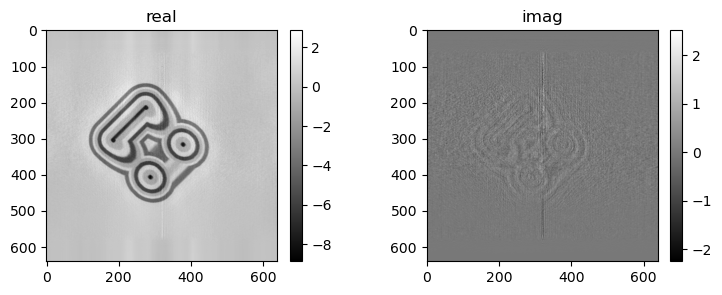

113), float(alpha)=1.8503075978064802 err=2.20768e+02
114), float(alpha)=1.4809986656338563 err=2.15163e+02
115), float(alpha)=1.559446922556848 err=2.09759e+02
116), float(alpha)=1.7163320967977975 err=2.03859e+02
117), float(alpha)=1.5773522163006535 err=1.98838e+02
118), float(alpha)=1.5763670510450132 err=1.93788e+02
119), float(alpha)=1.442916762715248 err=1.88956e+02
120), float(alpha)=1.6871701239530554 err=1.84122e+02
121), float(alpha)=1.6733134070592213 err=1.79325e+02
122), float(alpha)=1.4220212941150678 err=1.75149e+02
123), float(alpha)=1.5266554245466981 err=1.70708e+02
124), float(alpha)=1.6071234939247168 err=1.66474e+02
125), float(alpha)=1.7957289083070667 err=1.62031e+02
126), float(alpha)=1.7845594313772635 err=1.57719e+02
127), float(alpha)=1.809902893444667 err=1.53737e+02
128), float(alpha)=1.572219174202332 err=1.49850e+02


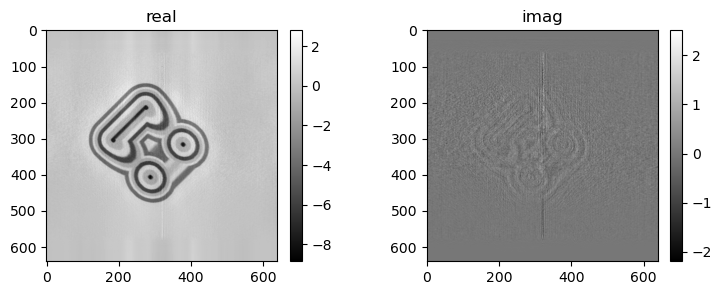

129), float(alpha)=1.554101924248854 err=1.46387e+02
130), float(alpha)=1.6036759155989864 err=1.42694e+02
131), float(alpha)=1.4205625689164914 err=1.39480e+02
132), float(alpha)=1.6889759481230866 err=1.36019e+02
133), float(alpha)=1.5251351310471175 err=1.32619e+02
134), float(alpha)=1.5753865700761358 err=1.29636e+02
135), float(alpha)=1.651476648641495 err=1.26347e+02
136), float(alpha)=1.4245053473085694 err=1.23468e+02
137), float(alpha)=1.8218815328365456 err=1.20363e+02
138), float(alpha)=1.5466683288072962 err=1.17453e+02
139), float(alpha)=1.5644303670329052 err=1.14814e+02
140), float(alpha)=1.6177923821565563 err=1.11928e+02
141), float(alpha)=1.6460755961840898 err=1.09280e+02
142), float(alpha)=1.8641658583673428 err=1.06447e+02
143), float(alpha)=1.5394818541949795 err=1.04025e+02
144), float(alpha)=1.5837512544692105 err=1.01677e+02


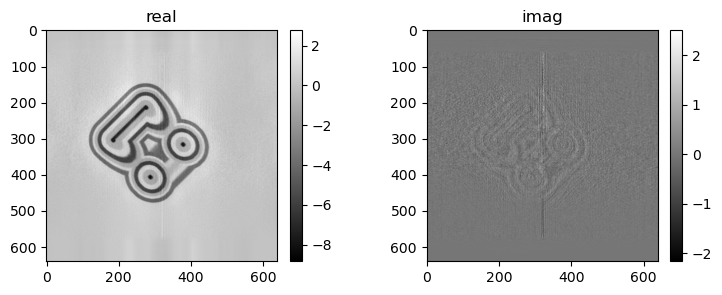

145), float(alpha)=1.4836130963560297 err=9.92653e+01
146), float(alpha)=1.594543066112073 err=9.70141e+01
147), float(alpha)=1.563532808250151 err=9.47602e+01
148), float(alpha)=1.4549584192520917 err=9.26390e+01
149), float(alpha)=1.7010993074342582 err=9.04212e+01
150), float(alpha)=1.7040966920302554 err=8.82174e+01
151), float(alpha)=1.760380324131341 err=8.61038e+01
152), float(alpha)=1.8003137380263554 err=8.39688e+01
153), float(alpha)=1.6271762186981082 err=8.21023e+01
154), float(alpha)=1.565022614503628 err=8.02279e+01
155), float(alpha)=1.4529809603848116 err=7.84639e+01
156), float(alpha)=1.6978779571591316 err=7.66300e+01
157), float(alpha)=1.583139824330931 err=7.48790e+01
158), float(alpha)=1.4931595954971546 err=7.33216e+01
159), float(alpha)=1.5689079308275673 err=7.16111e+01
160), float(alpha)=1.5378631985006446 err=7.00401e+01


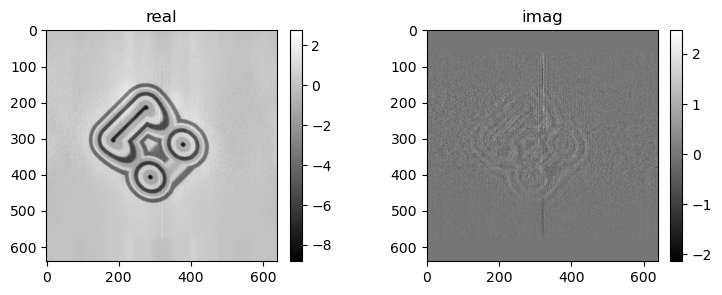

161), float(alpha)=1.7297403931717379 err=6.84173e+01
162), float(alpha)=1.5592997427312305 err=6.68992e+01
163), float(alpha)=1.5508675299019894 err=6.54720e+01
164), float(alpha)=1.6689358469306486 err=6.39326e+01
165), float(alpha)=1.5065705548603572 err=6.25715e+01
166), float(alpha)=1.7605599218194865 err=6.11148e+01
167), float(alpha)=1.608238082952252 err=5.97416e+01
168), float(alpha)=1.7768178732238995 err=5.84131e+01
169), float(alpha)=1.55736213055875 err=5.70912e+01
170), float(alpha)=1.4394114693230324 err=5.59386e+01
171), float(alpha)=1.6403393476163144 err=5.47197e+01
172), float(alpha)=1.4916546714518029 err=5.35177e+01
173), float(alpha)=1.5401964386345708 err=5.24241e+01
174), float(alpha)=1.685995874431442 err=5.12292e+01
175), float(alpha)=1.585149759212493 err=5.01214e+01
176), float(alpha)=1.7452393137721878 err=4.90075e+01


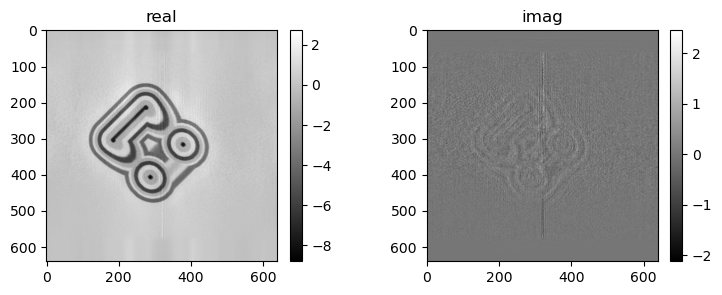

177), float(alpha)=1.7277161664023313 err=4.78917e+01
178), float(alpha)=1.513623628788165 err=4.69344e+01
179), float(alpha)=1.5516665527933737 err=4.59291e+01
180), float(alpha)=1.553372177944058 err=4.49327e+01
181), float(alpha)=1.8425604638167077 err=4.39251e+01
182), float(alpha)=1.7202314679994566 err=4.29407e+01
183), float(alpha)=1.5444856231475645 err=4.20834e+01
184), float(alpha)=1.410641570738607 err=4.12277e+01
185), float(alpha)=1.5248291346632086 err=4.03716e+01
186), float(alpha)=1.7759206577775077 err=3.94839e+01
187), float(alpha)=1.623089194239343 err=3.86315e+01
188), float(alpha)=1.6527206896898285 err=3.78247e+01
189), float(alpha)=1.6730755457475015 err=3.70103e+01
190), float(alpha)=1.5920141458109454 err=3.62353e+01
191), float(alpha)=1.682959175052236 err=3.54573e+01
192), float(alpha)=1.6296047315083622 err=3.47169e+01


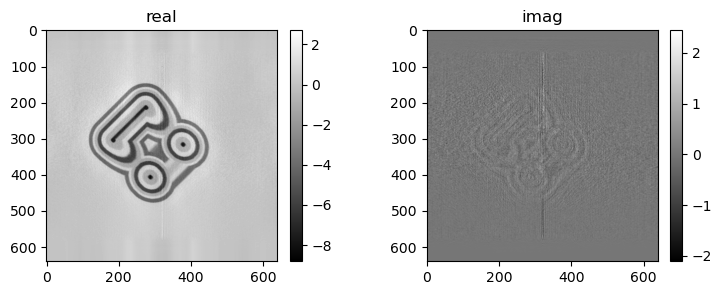

193), float(alpha)=1.59860379282843 err=3.40135e+01
194), float(alpha)=1.5474926850796402 err=3.33055e+01
195), float(alpha)=1.512683712467807 err=3.26449e+01
196), float(alpha)=1.6277462581281827 err=3.19589e+01
197), float(alpha)=1.5440611328660883 err=3.13045e+01
198), float(alpha)=1.586876704518947 err=3.06769e+01
199), float(alpha)=1.5931528439437128 err=3.00281e+01
200), float(alpha)=1.4787859302959983 err=2.94430e+01
201), float(alpha)=1.666947623495577 err=2.88259e+01
202), float(alpha)=1.5920256216265047 err=2.82290e+01
203), float(alpha)=1.7763531641991537 err=2.76378e+01
204), float(alpha)=1.5126644027817489 err=2.70785e+01
205), float(alpha)=1.5967517740958173 err=2.65327e+01
206), float(alpha)=1.8131259294219408 err=2.59482e+01
207), float(alpha)=1.7482140408508102 err=2.54039e+01
208), float(alpha)=1.658533196948236 err=2.48939e+01


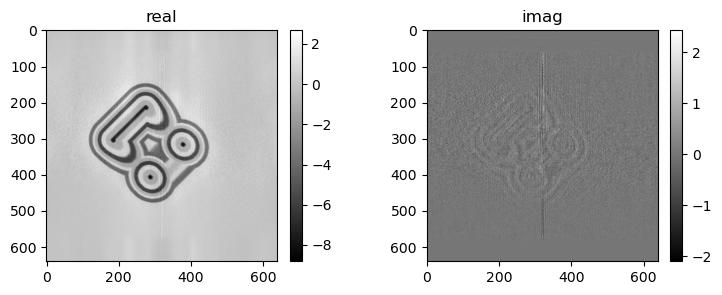

209), float(alpha)=1.313866656034488 err=2.44271e+01
210), float(alpha)=1.5860339315165388 err=2.39340e+01
211), float(alpha)=1.7332801473997093 err=2.34216e+01
212), float(alpha)=1.7465345695322794 err=2.29444e+01
213), float(alpha)=1.6404085191183075 err=2.24768e+01
214), float(alpha)=1.571180063710837 err=2.20271e+01
215), float(alpha)=1.5865101575273666 err=2.15914e+01
216), float(alpha)=1.6616091523087833 err=2.11503e+01
217), float(alpha)=1.7249831930405448 err=2.07104e+01
218), float(alpha)=1.5888794969834574 err=2.03079e+01
219), float(alpha)=1.5452080684566254 err=1.99058e+01
220), float(alpha)=1.482584438367712 err=1.95223e+01
221), float(alpha)=1.658376220362275 err=1.91338e+01
222), float(alpha)=1.554615750571456 err=1.87540e+01
223), float(alpha)=1.5431398836973276 err=1.84014e+01
224), float(alpha)=1.5897767097536133 err=1.80383e+01


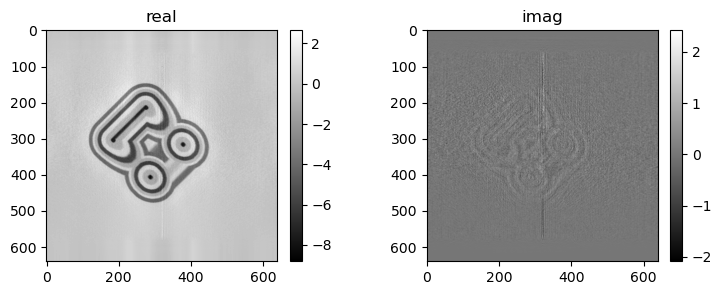

225), float(alpha)=1.5617883922838345 err=1.76826e+01
226), float(alpha)=1.636479660233182 err=1.73337e+01
227), float(alpha)=1.5790142489906671 err=1.69932e+01
228), float(alpha)=1.6544590939940016 err=1.66573e+01
229), float(alpha)=1.6220310695900413 err=1.63297e+01
230), float(alpha)=1.6437318434089931 err=1.60014e+01
231), float(alpha)=1.7949667165301726 err=1.56723e+01
232), float(alpha)=1.6537172125273203 err=1.53636e+01
233), float(alpha)=1.5641627843129615 err=1.50760e+01
234), float(alpha)=1.4871892165268723 err=1.47870e+01
235), float(alpha)=1.4649999603062722 err=1.45120e+01
236), float(alpha)=1.6733271119736746 err=1.42253e+01
237), float(alpha)=1.6554315003769768 err=1.39430e+01
238), float(alpha)=1.6783734066821085 err=1.36741e+01
239), float(alpha)=1.5441217174279214 err=1.34111e+01
240), float(alpha)=1.4974009220208107 err=1.31618e+01


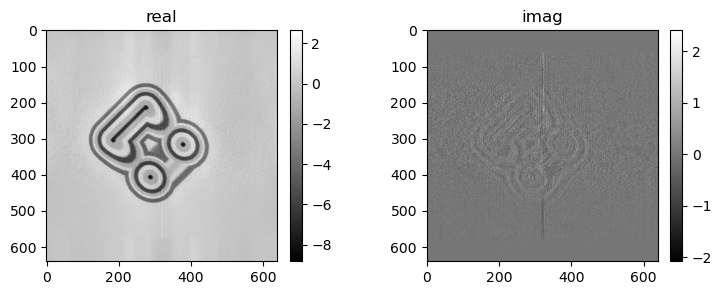

241), float(alpha)=1.6442118422238603 err=1.29036e+01
242), float(alpha)=1.729608674091366 err=1.26470e+01
243), float(alpha)=1.7831390041336734 err=1.23865e+01
244), float(alpha)=1.6480293572130256 err=1.21514e+01
245), float(alpha)=1.5762219045884907 err=1.19248e+01
246), float(alpha)=1.5067473531196498 err=1.16977e+01
247), float(alpha)=1.633947074978747 err=1.14781e+01
248), float(alpha)=1.5410082239524046 err=1.12584e+01
249), float(alpha)=1.4417820607800629 err=1.10600e+01
250), float(alpha)=1.6468557166227076 err=1.08423e+01
251), float(alpha)=1.674808784773485 err=1.06313e+01
252), float(alpha)=1.8171463988350747 err=1.04176e+01
253), float(alpha)=1.6571501973643605 err=1.02142e+01
254), float(alpha)=1.5074370417950422 err=1.00340e+01
255), float(alpha)=1.6257167089142313 err=9.84035e+00
256), float(alpha)=1.7079614375680106 err=9.64746e+00


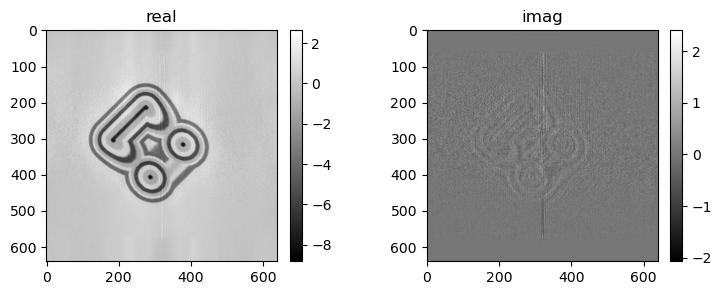

257), float(alpha)=1.6300454030915557 err=9.46653e+00
258), float(alpha)=1.4835742009406625 err=9.29676e+00
259), float(alpha)=1.5283563190458334 err=9.12349e+00
260), float(alpha)=1.6667710940501945 err=8.94969e+00
261), float(alpha)=1.643365685595009 err=8.78289e+00
262), float(alpha)=1.4627743647250637 err=8.62570e+00
263), float(alpha)=1.5965670732206694 err=8.46384e+00
264), float(alpha)=1.5434315201238193 err=8.30807e+00
265), float(alpha)=1.594307761387041 err=8.15539e+00
266), float(alpha)=1.7422964009217483 err=7.99197e+00
267), float(alpha)=1.7627386947464687 err=7.84127e+00
268), float(alpha)=1.888554527678563 err=7.67893e+00
269), float(alpha)=1.6374623201211511 err=7.53774e+00
270), float(alpha)=1.5224722202571837 err=7.40718e+00
271), float(alpha)=1.487923959354975 err=7.26780e+00
272), float(alpha)=1.6857805697325932 err=7.13439e+00


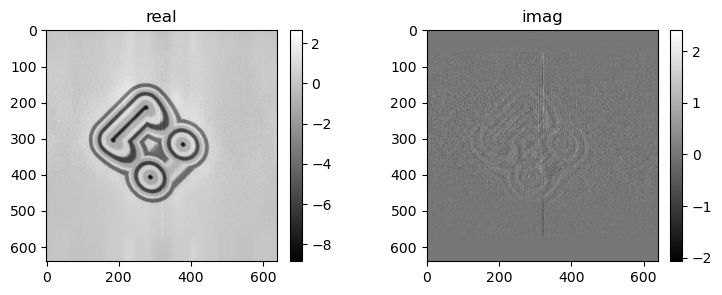

273), float(alpha)=1.5342759342639787 err=7.00400e+00
274), float(alpha)=1.4460166297595047 err=6.88310e+00
275), float(alpha)=1.6961734763782816 err=6.75014e+00
276), float(alpha)=1.635703826878441 err=6.62275e+00
277), float(alpha)=1.8029077775164737 err=6.49973e+00
278), float(alpha)=1.5757957239558322 err=6.37589e+00
279), float(alpha)=1.5891242846006886 err=6.26574e+00
280), float(alpha)=1.6753700080850833 err=6.14161e+00
281), float(alpha)=1.5497168875967033 err=6.03519e+00
282), float(alpha)=1.8128089118903015 err=5.91963e+00
283), float(alpha)=1.3907412888161443 err=5.81481e+00
284), float(alpha)=1.5888089248927435 err=5.71488e+00
285), float(alpha)=1.689768519444202 err=5.60197e+00
286), float(alpha)=1.5129735616335602 err=5.50646e+00
287), float(alpha)=1.6468494184344544 err=5.40613e+00
288), float(alpha)=1.4307749343266667 err=5.31102e+00


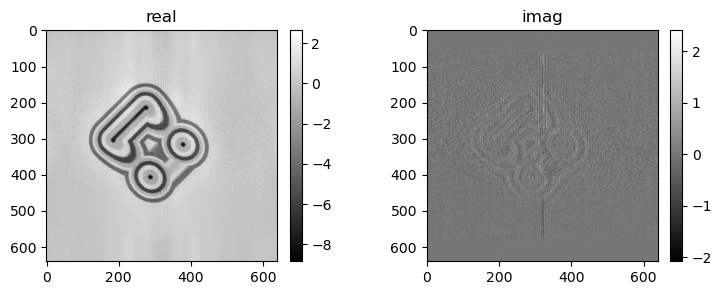

289), float(alpha)=1.59329657296181 err=5.21901e+00
290), float(alpha)=1.6794012418677429 err=5.11749e+00
291), float(alpha)=1.6882984207785252 err=5.02531e+00
292), float(alpha)=1.7999245216771491 err=4.92810e+00
293), float(alpha)=1.6374271121637816 err=4.83745e+00
294), float(alpha)=1.7945374982684594 err=4.74855e+00
295), float(alpha)=1.484789052609444 err=4.66423e+00
296), float(alpha)=1.451166600786217 err=4.58817e+00
297), float(alpha)=1.7031992026402007 err=4.49979e+00
298), float(alpha)=1.6000598091584648 err=4.42101e+00
299), float(alpha)=1.5898426914288086 err=4.34410e+00
300), float(alpha)=1.4559615849886878 err=4.26702e+00
301), float(alpha)=1.609899790675609 err=4.19349e+00
302), float(alpha)=1.725071324266053 err=4.11296e+00
303), float(alpha)=1.5313318460426326 err=4.04325e+00
304), float(alpha)=1.6489870803453794 err=3.97168e+00


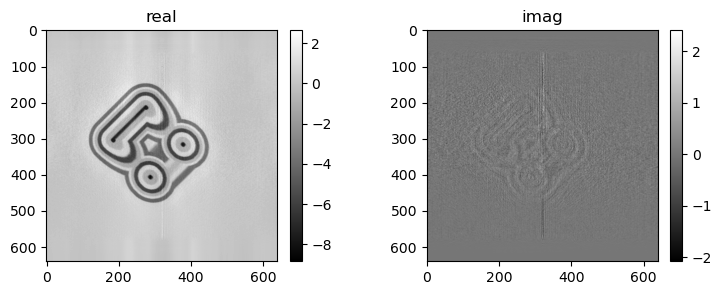

305), float(alpha)=1.5363818186820568 err=3.89963e+00
306), float(alpha)=1.8073771935047471 err=3.82737e+00
307), float(alpha)=1.855247579925065 err=3.75301e+00
308), float(alpha)=1.6009151398289079 err=3.68960e+00
309), float(alpha)=1.466735681563189 err=3.62529e+00
310), float(alpha)=1.551597619617932 err=3.56327e+00
311), float(alpha)=1.6820815949972105 err=3.49901e+00
312), float(alpha)=1.430934517610971 err=3.44064e+00
313), float(alpha)=1.575411647944738 err=3.38096e+00
314), float(alpha)=1.6651081546175248 err=3.31789e+00
315), float(alpha)=1.736707635538409 err=3.25920e+00
316), float(alpha)=1.7678061698541057 err=3.19815e+00
317), float(alpha)=1.6041607938662925 err=3.14282e+00
318), float(alpha)=1.6299867409469508 err=3.08795e+00
319), float(alpha)=1.5399596605550232 err=3.03419e+00
320), float(alpha)=1.4945280369278944 err=2.98391e+00


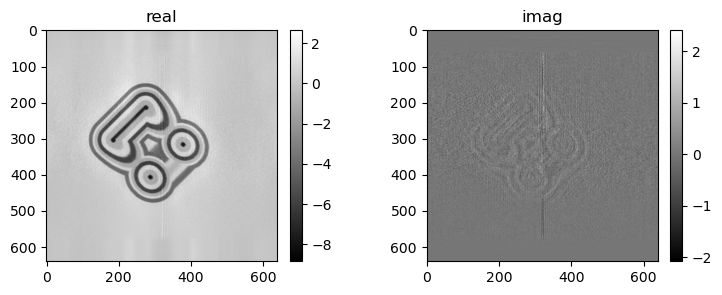

321), float(alpha)=1.7298734586918698 err=2.92881e+00
322), float(alpha)=1.707632302557727 err=2.87560e+00
323), float(alpha)=1.6599513258910725 err=2.82625e+00
324), float(alpha)=1.39890680428539 err=2.78004e+00
325), float(alpha)=1.5692999069769975 err=2.73186e+00
326), float(alpha)=1.5904440645491893 err=2.68422e+00
327), float(alpha)=1.6233868913761274 err=2.63765e+00
328), float(alpha)=1.6552104969504888 err=2.59081e+00
329), float(alpha)=1.7380188657207205 err=2.54474e+00
330), float(alpha)=1.5915951801175054 err=2.50041e+00
331), float(alpha)=1.5883408917214663 err=2.45788e+00
332), float(alpha)=1.7895904229090562 err=2.41233e+00
333), float(alpha)=1.6517023799627528 err=2.37048e+00
334), float(alpha)=1.6408588199651584 err=2.33021e+00
335), float(alpha)=1.3937156872707126 err=2.29204e+00
336), float(alpha)=1.631048863367992 err=2.25234e+00


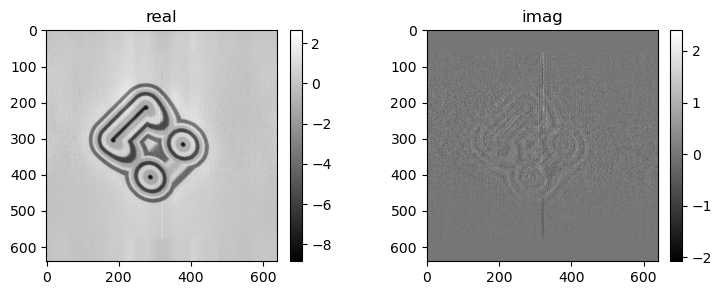

337), float(alpha)=1.6914514840251424 err=2.21297e+00
338), float(alpha)=1.3966033289204363 err=2.17780e+00
339), float(alpha)=1.6240002255507013 err=2.13997e+00
340), float(alpha)=1.7715065239677308 err=2.10047e+00
341), float(alpha)=1.7538001530462124 err=2.06360e+00
342), float(alpha)=1.712785312069461 err=2.02791e+00
343), float(alpha)=1.480009363912162 err=1.99441e+00
344), float(alpha)=1.5577161742053602 err=1.96102e+00
345), float(alpha)=1.6685204417037258 err=1.92618e+00
346), float(alpha)=1.5920070498059977 err=1.89405e+00
347), float(alpha)=1.7276448437213106 err=1.86071e+00
348), float(alpha)=1.5869106970298292 err=1.82911e+00
349), float(alpha)=1.543014946212636 err=1.79919e+00
350), float(alpha)=1.4479397825634392 err=1.76982e+00
351), float(alpha)=1.5541657397872297 err=1.74038e+00
352), float(alpha)=1.7542708777364182 err=1.70904e+00


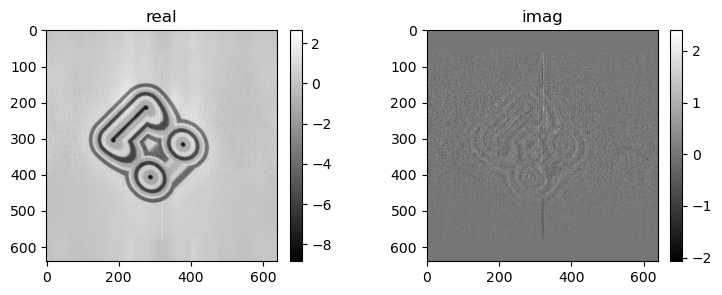

353), float(alpha)=1.6702571127336068 err=1.68001e+00
354), float(alpha)=1.679081835120753 err=1.65101e+00
355), float(alpha)=1.5130381147868388 err=1.62360e+00
356), float(alpha)=1.7098572991720282 err=1.59579e+00
357), float(alpha)=1.684398542103732 err=1.56766e+00
358), float(alpha)=1.6050747395176233 err=1.54155e+00
359), float(alpha)=1.6097482898539144 err=1.51609e+00
360), float(alpha)=1.4739053788058079 err=1.49137e+00
361), float(alpha)=1.630034763223146 err=1.46612e+00
362), float(alpha)=1.7287145393985635 err=1.44048e+00
363), float(alpha)=1.4667384094576839 err=1.41779e+00
364), float(alpha)=1.4850954397388774 err=1.39464e+00
365), float(alpha)=1.6357396041792467 err=1.37106e+00
366), float(alpha)=1.6648485480280835 err=1.34757e+00
367), float(alpha)=1.6832332947940662 err=1.32476e+00
368), float(alpha)=1.486705531732644 err=1.30353e+00


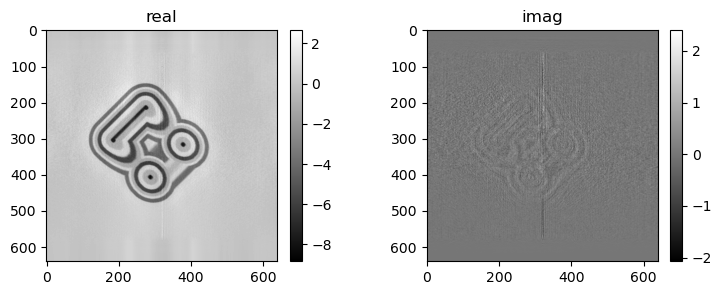

369), float(alpha)=1.6695404000180598 err=1.28103e+00
370), float(alpha)=1.7923076308159955 err=1.25833e+00
371), float(alpha)=1.76919396157896 err=1.23669e+00
372), float(alpha)=1.7283899000111236 err=1.21546e+00
373), float(alpha)=1.5129857308126695 err=1.19593e+00
374), float(alpha)=1.4571291151455934 err=1.17730e+00
375), float(alpha)=1.5138727326636385 err=1.15817e+00
376), float(alpha)=1.6843666540131106 err=1.13818e+00
377), float(alpha)=1.8086499551156434 err=1.11852e+00
378), float(alpha)=1.5378616633180628 err=1.10034e+00
379), float(alpha)=1.5060149213461782 err=1.08306e+00
380), float(alpha)=1.649289142138574 err=1.06454e+00
381), float(alpha)=1.5908641799829593 err=1.04737e+00
382), float(alpha)=1.7018201552516967 err=1.02962e+00
383), float(alpha)=1.587147787907989 err=1.01241e+00
384), float(alpha)=1.6740292830516534 err=9.95780e-01


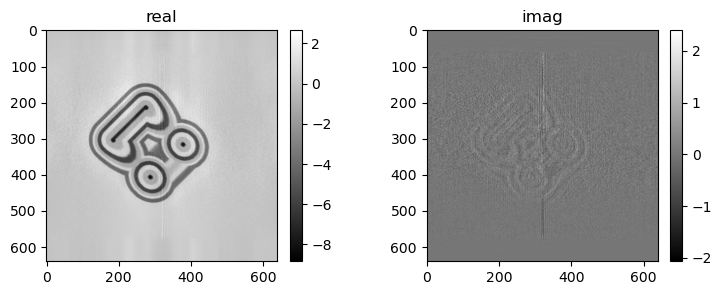

385), float(alpha)=1.6263609400015744 err=9.79063e-01
386), float(alpha)=1.5961028910028559 err=9.63747e-01
387), float(alpha)=1.6117376673457198 err=9.47438e-01
388), float(alpha)=1.4489578676832118 err=9.32704e-01
389), float(alpha)=1.5414593288340606 err=9.17846e-01
390), float(alpha)=1.5941588400440259 err=9.02611e-01
391), float(alpha)=1.7057882816060694 err=8.87561e-01
392), float(alpha)=1.6878427973122871 err=8.72594e-01
393), float(alpha)=1.6385508062996064 err=8.58447e-01
394), float(alpha)=1.5854534996995784 err=8.44404e-01
395), float(alpha)=1.6508550868431389 err=8.30503e-01
396), float(alpha)=1.650672595592009 err=8.16771e-01
397), float(alpha)=1.7318996948552534 err=8.03035e-01
398), float(alpha)=1.6103461506621823 err=7.90030e-01
399), float(alpha)=1.4221813035533655 err=7.78225e-01
400), float(alpha)=1.5342836070028196 err=7.65683e-01


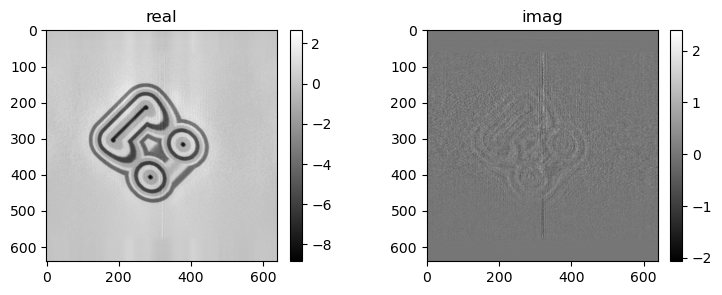

401), float(alpha)=1.6290549454519756 err=7.52891e-01
402), float(alpha)=1.7672275171226945 err=7.40247e-01
403), float(alpha)=1.5811850581022555 err=7.28432e-01
404), float(alpha)=1.5661888025245154 err=7.17249e-01
405), float(alpha)=1.532964395969449 err=7.05466e-01
406), float(alpha)=1.6257808620746532 err=6.94116e-01
407), float(alpha)=1.8078229496203475 err=6.82187e-01
408), float(alpha)=1.5709708295544997 err=6.71256e-01
409), float(alpha)=1.669315659229354 err=6.60532e-01
410), float(alpha)=1.5987748879494315 err=6.49877e-01
411), float(alpha)=1.6021698565526192 err=6.39485e-01
412), float(alpha)=1.6381325695488913 err=6.29076e-01
413), float(alpha)=1.482049986454207 err=6.19573e-01
414), float(alpha)=1.4873222941990782 err=6.09923e-01
415), float(alpha)=1.6423203479269282 err=6.00015e-01
416), float(alpha)=1.6152234150661857 err=5.90404e-01


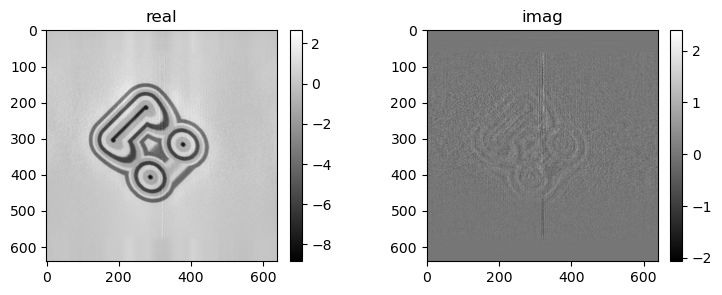

417), float(alpha)=1.6949414693256803 err=5.80751e-01
418), float(alpha)=1.6209218461861539 err=5.71385e-01
419), float(alpha)=1.6237328828128006 err=5.62429e-01
420), float(alpha)=1.6201213921970468 err=5.53383e-01
421), float(alpha)=1.5805994769642209 err=5.44616e-01
422), float(alpha)=1.7015698016651442 err=5.35706e-01
423), float(alpha)=1.590038603306793 err=5.27323e-01
424), float(alpha)=1.5301974904473503 err=5.19290e-01
425), float(alpha)=1.6216770615360532 err=5.10748e-01
426), float(alpha)=1.543205765491866 err=5.03029e-01
427), float(alpha)=1.662560044219396 err=4.94979e-01
428), float(alpha)=1.4634470068425032 err=4.87447e-01
429), float(alpha)=1.5250916425390897 err=4.80050e-01
430), float(alpha)=1.6298027772247645 err=4.72108e-01
431), float(alpha)=1.7585931460157054 err=4.64500e-01
432), float(alpha)=1.9116388309977832 err=4.56283e-01


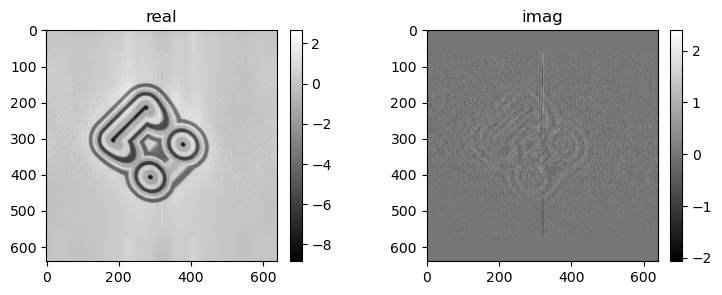

433), float(alpha)=1.6519938622267625 err=4.49227e-01
434), float(alpha)=1.7900367001428332 err=4.41687e-01
435), float(alpha)=1.4504156974913596 err=4.35257e-01
436), float(alpha)=1.543155728977394 err=4.28550e-01
437), float(alpha)=1.577087163959876 err=4.21580e-01
438), float(alpha)=1.6597627255430139 err=4.15185e-01
439), float(alpha)=1.5475253250789787 err=4.08632e-01
440), float(alpha)=1.494182834812467 err=4.02526e-01
441), float(alpha)=1.686557092977291 err=3.96076e-01
442), float(alpha)=1.6254167179260144 err=3.89759e-01
443), float(alpha)=1.5207927002189943 err=3.84041e-01
444), float(alpha)=1.551353200154745 err=3.77974e-01
445), float(alpha)=1.7946618789401867 err=3.71607e-01
446), float(alpha)=1.751565211778776 err=3.65734e-01
447), float(alpha)=1.7589467407515889 err=3.59668e-01
448), float(alpha)=1.64803254447659 err=3.54164e-01


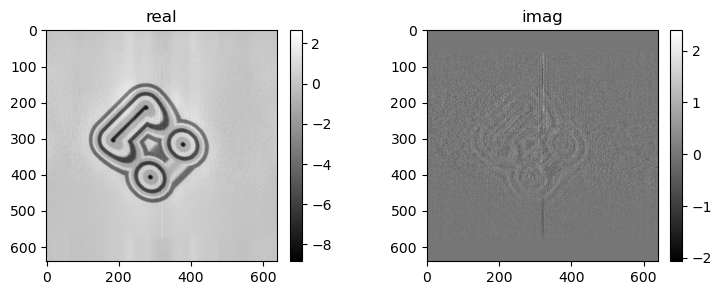

449), float(alpha)=1.538122334351058 err=3.48684e-01
450), float(alpha)=1.4594576511238297 err=3.43529e-01
451), float(alpha)=1.617734658988918 err=3.38233e-01
452), float(alpha)=1.5926360687357333 err=3.32945e-01
453), float(alpha)=1.501434515898074 err=3.27977e-01
454), float(alpha)=1.6417331157943358 err=3.22819e-01
455), float(alpha)=1.639124904213018 err=3.17696e-01
456), float(alpha)=1.7150579847748146 err=3.12776e-01
457), float(alpha)=1.648040399830002 err=3.07706e-01
458), float(alpha)=1.7054793551728777 err=3.02932e-01
459), float(alpha)=1.8156129938187269 err=2.97869e-01
460), float(alpha)=1.446946356857355 err=2.93672e-01
461), float(alpha)=1.556302890781312 err=2.89208e-01
462), float(alpha)=1.5577913272835924 err=2.84646e-01
463), float(alpha)=1.7628237227045616 err=2.80228e-01
464), float(alpha)=1.5102115867297645 err=2.76017e-01


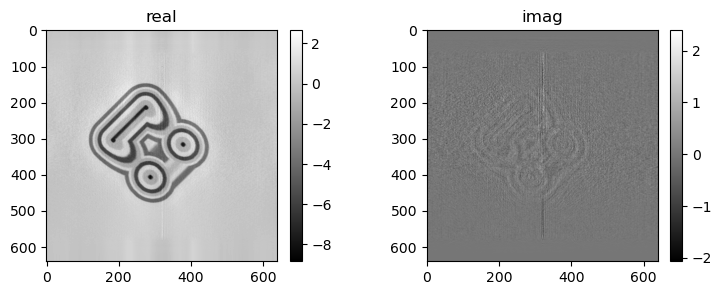

465), float(alpha)=1.4363867142574378 err=2.72077e-01
466), float(alpha)=1.736933866260987 err=2.67636e-01
467), float(alpha)=1.5950873604431308 err=2.63590e-01
468), float(alpha)=1.6105822718871206 err=2.59625e-01
469), float(alpha)=1.4896879005713446 err=2.55651e-01
470), float(alpha)=1.7367158515740333 err=2.51702e-01
471), float(alpha)=1.7955602777936588 err=2.47533e-01
472), float(alpha)=1.6437576893861523 err=2.43831e-01
473), float(alpha)=1.717049557881092 err=2.39926e-01
474), float(alpha)=1.3885677161074579 err=2.36511e-01
475), float(alpha)=1.7480973550110108 err=2.32855e-01
476), float(alpha)=1.5297850582392791 err=2.29253e-01
477), float(alpha)=1.4909658635644663 err=2.26053e-01
478), float(alpha)=1.586835345135305 err=2.22501e-01
479), float(alpha)=1.5362953551194884 err=2.19220e-01
480), float(alpha)=1.848533425507034 err=2.15660e-01


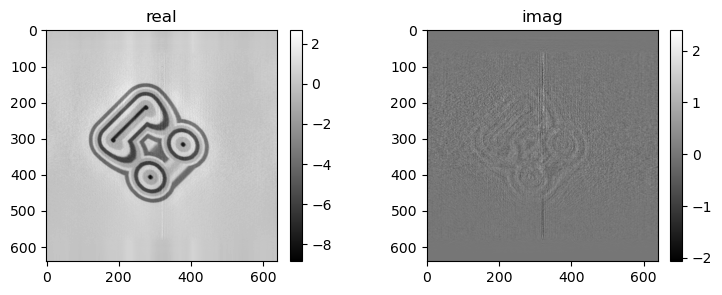

481), float(alpha)=1.5425582580210295 err=2.12430e-01
482), float(alpha)=1.7501841933360864 err=2.09178e-01
483), float(alpha)=1.6058060915651176 err=2.05902e-01
484), float(alpha)=1.4982133821374646 err=2.03041e-01
485), float(alpha)=1.6324501210324867 err=1.99782e-01
486), float(alpha)=1.6320962925544933 err=1.96810e-01
487), float(alpha)=1.8327232934873845 err=1.93641e-01
488), float(alpha)=1.501279971381883 err=1.90803e-01
489), float(alpha)=1.5822680730015124 err=1.88066e-01
490), float(alpha)=1.3797248959509807 err=1.85342e-01
491), float(alpha)=1.6947322268777911 err=1.82471e-01
492), float(alpha)=1.8578395507891774 err=1.79490e-01
493), float(alpha)=1.6026412994341666 err=1.76901e-01
494), float(alpha)=1.6602885026625471 err=1.74132e-01
495), float(alpha)=1.5844548608330693 err=1.71525e-01
496), float(alpha)=1.7782790205639099 err=1.68859e-01


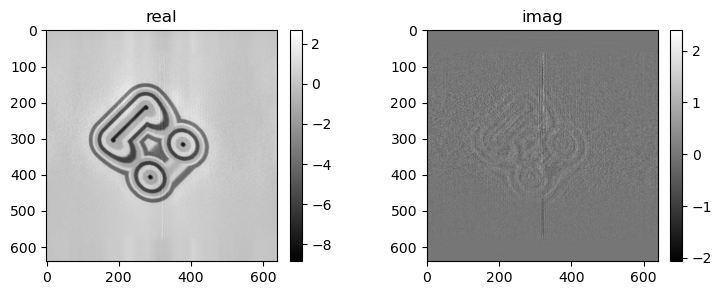

497), float(alpha)=1.6886394775334823 err=1.66263e-01
498), float(alpha)=1.5486537941038017 err=1.63886e-01
499), float(alpha)=1.450006286753551 err=1.61531e-01
500), float(alpha)=1.6129801366376857 err=1.59092e-01
501), float(alpha)=1.6635744407442667 err=1.56660e-01
502), float(alpha)=1.6434394528304634 err=1.54375e-01
503), float(alpha)=1.4896084830039935 err=1.52104e-01
504), float(alpha)=1.5135024769292735 err=1.49951e-01
505), float(alpha)=1.6336837504259936 err=1.47685e-01
506), float(alpha)=1.6588840148966473 err=1.45407e-01
507), float(alpha)=1.8452262862444608 err=1.43132e-01
508), float(alpha)=1.6388877462463016 err=1.40973e-01
509), float(alpha)=1.5485996159922206 err=1.39010e-01
510), float(alpha)=1.71417298868994 err=1.36807e-01
511), float(alpha)=1.5897660569211112 err=1.34815e-01
512), float(alpha)=1.7144673104918011 err=1.32791e-01


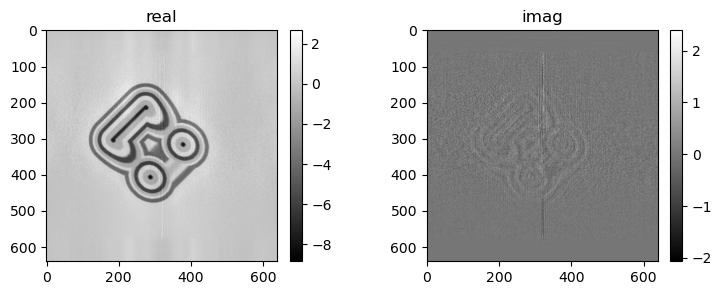

In [14]:

def hessian2(Lpsi,Lpsi1,Lpsi2,data):
    l0 = Lpsi/np.abs(Lpsi)
    d0 = data/np.abs(Lpsi)
    v1 = redot(1-d0,np.real(Lpsi1*np.conj(Lpsi2)))
    v2 = redot(d0,np.real(np.conj(l0)*Lpsi1)*np.real(np.conj(l0)*Lpsi2))
    return 2*(v1+v2)

def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f
    
def cg(data, init_u, prb, pars):

    data = np.sqrt(data)
    u = init_u.copy()    

    conv = np.zeros(pars['niter'])
    alphaa = np.zeros(pars['niter'])    
    center_pad = u.shape[-1]//2
    for i in range(pars['niter']):
        
        # \nabla(F)_X
        eR = np.exp(1j*R(u,theta,center_pad).swapaxes(0,1))
        Lpsi = fwd_holo(eR,prb)        
        gradF = 2*adj_holo(Lpsi-data*np.exp(1j*np.angle(Lpsi)),prb)        
               
        # \nabla(G)_U0
        grad = np.conj(eR)*gradF
        grad = -1j*RT(grad.swapaxes(0,1),theta,center_pad)                                
        
        Rgrad = R(grad,theta,center_pad).swapaxes(0,1)
        
        if i == 0:
            eta = -grad            
            Reta = -Rgrad
        else:                     
            Lpsi = fwd_holo(eR,prb)
            Lgrad = fwd_holo(eR*(1j*Rgrad),prb)
            Leta = fwd_holo(eR*(1j*Reta),prb)

            top = redot(gradF,eR*(1j*Rgrad)*(1j*Reta))
            top += hessian2(Lpsi,Lgrad,Leta,data)

            bottom = redot(gradF,eR*(1j*Reta)*(1j*Reta))
            bottom += hessian2(Lpsi,Leta,Leta,data)

            beta = top/bottom
            
            eta = -grad + beta*eta
            Reta = -Rgrad + beta*Reta  

        
        top = -redot(grad,eta)      
        bottom = redot(gradF,eR*(1j*Reta)**2)

        Lpsi = fwd_holo(eR,prb)
        Leta = fwd_holo(eR*(1j*Reta),prb)     
        bottom += hessian2(Lpsi,Leta,Leta,data)
                
        alpha = top/bottom
        u += alpha*eta
        
        if i % pars['err_step'] == 0:
            eR = np.exp(1j*R(u,theta,u.shape[-1]//2).swapaxes(0,1))
            Lpsi = fwd_holo(eR,prb)
            err = minf(Lpsi,data)
            conv[i] = err
            alphaa[i] = alpha
            print(f'{i}), {float(alpha)=} {err=:1.5e}')

        if i % pars['vis_step'] == 0 and pars['vis_step'] > -1 :
            mshow_complex(u[:,ne//2+3,:],show)            
            
    return u,conv,alphaa

urec = urec0.copy()
rec_prb = prb.copy()

# urec = cp.array(urec)
# data=cp.array(data)
# rec_prb = cp.array(rec_prb)
# shifts_code=cp.array(shifts_code)
pars = {'niter': 513, 'err_step': 1, 'vis_step': 16}

urec,conv,step = cg(data, urec,rec_prb, pars)



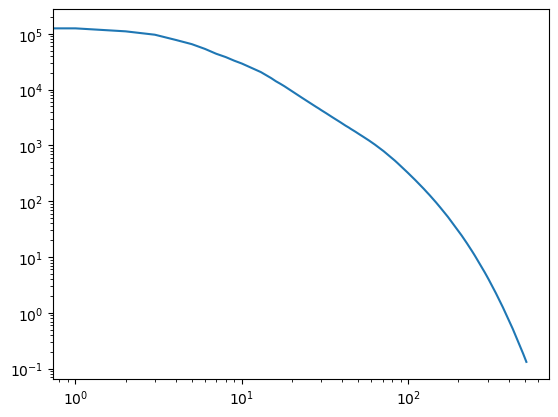

In [17]:
plt.loglog(conv)